## NLP Knowledge Graph (using n10s, APOC)

In [1]:
#Imports
from neo4j import GraphDatabase
import os
import pandas as pd

In [2]:
#Connection Environments
URI = os.environ["NEO4J_URI"]
USER=os.environ["NEO4J_USER_NAME"]
PASSWORD=os.environ["NEO4J_PASSWD"]
AUTH = (os.environ["NEO4J_USER_NAME"], os.environ["NEO4J_PASSWD"])

In [17]:
#Neo4J connect and Query Boilerplate

class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            #response = (session.run(query, parameters))
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        
        #return pd.DataFrame([r.values() for r in response], columns=response.keys())
        return response
    
    def multi_query(self, multi_line_query, parameters=None, db=None):
        for li in multi_line_query.splitlines():
                print(li)
                result=self.query(li, parameters=None, db=None)
                print(result)
        

In [18]:
#Make a default connection and it should return `[<Record count(n)=0>]`

conn = Neo4jConnection(uri=URI, 
                       user=USER,              
                       pwd=PASSWORD)


#if db is empty, then seed with init values 
res=conn.query('MATCH (n) RETURN count(n)')
print(res)

[<Record count(n)=5>]


In [19]:
#Optional
#Clean Neo4J DB

res=conn.query("""
MATCH (n) DETACH DELETE n;
""")
print(res)


[]


In [20]:
# Configure n10s
config_n10s="""CREATE CONSTRAINT n10s_unique_uri FOR (r:Resource) REQUIRE r.uri IS UNIQUE;
CALL n10s.graphconfig.init({handleVocabUris: "MAP"});
CALL n10s.nsprefixes.add('neo','neo4j://voc#');
CALL n10s.mapping.add("neo4j://voc#subCatOf","SUB_CAT_OF");
CALL n10s.mapping.add("neo4j://voc#about","ABOUT");
"""
conn.multi_query(config_n10s)


CREATE CONSTRAINT n10s_unique_uri FOR (r:Resource) REQUIRE r.uri IS UNIQUE;
Query failed: {code: Neo.ClientError.Schema.EquivalentSchemaRuleAlreadyExists} {message: An equivalent constraint already exists, 'Constraint( id=4, name='n10s_unique_uri', type='UNIQUENESS', schema=(:Resource {uri}), ownedIndex=3 )'.}
None
CALL n10s.graphconfig.init({handleVocabUris: "MAP"});
[<Record param='handleVocabUris' value='MAP'>, <Record param='handleMultival' value='OVERWRITE'>, <Record param='handleRDFTypes' value='LABELS'>, <Record param='keepLangTag' value=False>, <Record param='keepCustomDataTypes' value=False>, <Record param='applyNeo4jNaming' value=False>, <Record param='baseSchemaNamespace' value='neo4j://graph.schema#'>, <Record param='baseSchemaPrefix' value='n4sch'>, <Record param='classLabel' value='Class'>, <Record param='subClassOfRel' value='SCO'>, <Record param='dataTypePropertyLabel' value='Property'>, <Record param='objectPropertyLabel' value='Relationship'>, <Record param='subProper

### 1. Import Taxonomy (Wikidata Software)

Import Wikipedia Structure data  on 
- Software systems
- Programming Languages
- Data formats 

Using SparQL queries into neo4j graph db 


In [24]:
#Import RDF Triples relating to DataFormats
input="""WITH "https://query.wikidata.org/sparql?query=prefix%20neo%3A%20%3Cneo4j%3A%2F%2Fvoc%23%3E%20%0A%23Cats%0A%23SELECT%20%3Fitem%20%3Flabel%20%0ACONSTRUCT%20%7B%0A%3Fitem%20a%20neo%3ACategory%20%3B%20neo%3AsubCatOf%20%3FparentItem%20.%20%20%0A%20%20%3Fitem%20neo%3Aname%20%3Flabel%20.%0A%20%20%3FparentItem%20a%20neo%3ACategory%3B%20neo%3Aname%20%3FparentLabel%20.%0A%20%20%3Farticle%20a%20neo%3AWikipediaPage%3B%20neo%3Aabout%20%3Fitem%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%0A%7D%0AWHERE%20%0A%7B%0A%20%20%3Fitem%20(wdt%3AP31%7Cwdt%3AP279)*%20wd%3AQ24451526%20.%0A%20%20%3Fitem%20wdt%3AP31%7Cwdt%3AP279%20%3FparentItem%20.%0A%20%20%3Fitem%20rdfs%3Alabel%20%3Flabel%20.%0A%20%20filter(lang(%3Flabel)%20%3D%20%22en%22)%0A%20%20%3FparentItem%20rdfs%3Alabel%20%3FparentLabel%20.%0A%20%20filter(lang(%3FparentLabel)%20%3D%20%22en%22)%0A%20%20%0A%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Farticle%20schema%3Aabout%20%3Fitem%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20schema%3AinLanguage%20%22en%22%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20schema%3AisPartOf%20%3Chttps%3A%2F%2Fen.wikipedia.org%2F%3E%20.%0A%20%20%20%20%7D%0A%20%20%0A%7D" AS dataFormatsUri
CALL n10s.rdf.import.fetch(dataFormatsUri, 'Turtle' , { headerParams: { Accept: "application/x-turtle" } })
YIELD terminationStatus, triplesLoaded, triplesParsed, namespaces, callParams
RETURN terminationStatus, triplesLoaded, triplesParsed, namespaces, callParams;"""
res=conn.query(input)
print(res)

[<Record terminationStatus='OK' triplesLoaded=609 triplesParsed=609 namespaces=None callParams={'headerParams': {'Accept': 'application/x-turtle'}, 'singleTx': False}>]


In [24]:
#Import RDF Triples relating to DataFormats
input="""WITH "https://query.wikidata.org/sparql?query=prefix%20neo%3A%20%3Cneo4j%3A%2F%2Fvoc%23%3E%20%0A%23Cats%0A%23SELECT%20%3Fitem%20%3Flabel%20%0ACONSTRUCT%20%7B%0A%3Fitem%20a%20neo%3ACategory%20%3B%20neo%3AsubCatOf%20%3FparentItem%20.%20%20%0A%20%20%3Fitem%20neo%3Aname%20%3Flabel%20.%0A%20%20%3FparentItem%20a%20neo%3ACategory%3B%20neo%3Aname%20%3FparentLabel%20.%0A%20%20%3Farticle%20a%20neo%3AWikipediaPage%3B%20neo%3Aabout%20%3Fitem%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%0A%7D%0AWHERE%20%0A%7B%0A%20%20%3Fitem%20(wdt%3AP31%7Cwdt%3AP279)*%20wd%3AQ24451526%20.%0A%20%20%3Fitem%20wdt%3AP31%7Cwdt%3AP279%20%3FparentItem%20.%0A%20%20%3Fitem%20rdfs%3Alabel%20%3Flabel%20.%0A%20%20filter(lang(%3Flabel)%20%3D%20%22en%22)%0A%20%20%3FparentItem%20rdfs%3Alabel%20%3FparentLabel%20.%0A%20%20filter(lang(%3FparentLabel)%20%3D%20%22en%22)%0A%20%20%0A%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Farticle%20schema%3Aabout%20%3Fitem%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20schema%3AinLanguage%20%22en%22%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20schema%3AisPartOf%20%3Chttps%3A%2F%2Fen.wikipedia.org%2F%3E%20.%0A%20%20%20%20%7D%0A%20%20%0A%7D" AS dataFormatsUri
CALL n10s.rdf.import.fetch(dataFormatsUri, 'Turtle' , { headerParams: { Accept: "application/x-turtle" } })
YIELD terminationStatus, triplesLoaded, triplesParsed, namespaces, callParams
RETURN terminationStatus, triplesLoaded, triplesParsed, namespaces, callParams;"""
res=conn.query(input)
print(res)

[<Record terminationStatus='OK' triplesLoaded=609 triplesParsed=609 namespaces=None callParams={'headerParams': {'Accept': 'application/x-turtle'}, 'singleTx': False}>]


In [24]:
#Import RDF Triples relating to DataFormats
input="""WITH "https://query.wikidata.org/sparql?query=prefix%20neo%3A%20%3Cneo4j%3A%2F%2Fvoc%23%3E%20%0A%23Cats%0A%23SELECT%20%3Fitem%20%3Flabel%20%0ACONSTRUCT%20%7B%0A%3Fitem%20a%20neo%3ACategory%20%3B%20neo%3AsubCatOf%20%3FparentItem%20.%20%20%0A%20%20%3Fitem%20neo%3Aname%20%3Flabel%20.%0A%20%20%3FparentItem%20a%20neo%3ACategory%3B%20neo%3Aname%20%3FparentLabel%20.%0A%20%20%3Farticle%20a%20neo%3AWikipediaPage%3B%20neo%3Aabout%20%3Fitem%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%0A%7D%0AWHERE%20%0A%7B%0A%20%20%3Fitem%20(wdt%3AP31%7Cwdt%3AP279)*%20wd%3AQ24451526%20.%0A%20%20%3Fitem%20wdt%3AP31%7Cwdt%3AP279%20%3FparentItem%20.%0A%20%20%3Fitem%20rdfs%3Alabel%20%3Flabel%20.%0A%20%20filter(lang(%3Flabel)%20%3D%20%22en%22)%0A%20%20%3FparentItem%20rdfs%3Alabel%20%3FparentLabel%20.%0A%20%20filter(lang(%3FparentLabel)%20%3D%20%22en%22)%0A%20%20%0A%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Farticle%20schema%3Aabout%20%3Fitem%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20schema%3AinLanguage%20%22en%22%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20schema%3AisPartOf%20%3Chttps%3A%2F%2Fen.wikipedia.org%2F%3E%20.%0A%20%20%20%20%7D%0A%20%20%0A%7D" AS dataFormatsUri
CALL n10s.rdf.import.fetch(dataFormatsUri, 'Turtle' , { headerParams: { Accept: "application/x-turtle" } })
YIELD terminationStatus, triplesLoaded, triplesParsed, namespaces, callParams
RETURN terminationStatus, triplesLoaded, triplesParsed, namespaces, callParams;"""
res=conn.query(input)
print(res)

[<Record terminationStatus='OK' triplesLoaded=609 triplesParsed=609 namespaces=None callParams={'headerParams': {'Accept': 'application/x-turtle'}, 'singleTx': False}>]


### 1.1 Querying the imported Software Taxonomy

#### Find all children of the Catergory names Version Control system that has a :[SUB_CAT_OF*]

//Paste the following to Neo4J Browser - http://localhost:7474
```
MATCH path = (c:Category {name: "version control system"})<-[:SUB_CAT_OF*]-(child)
RETURN path
LIMIT 25;
```

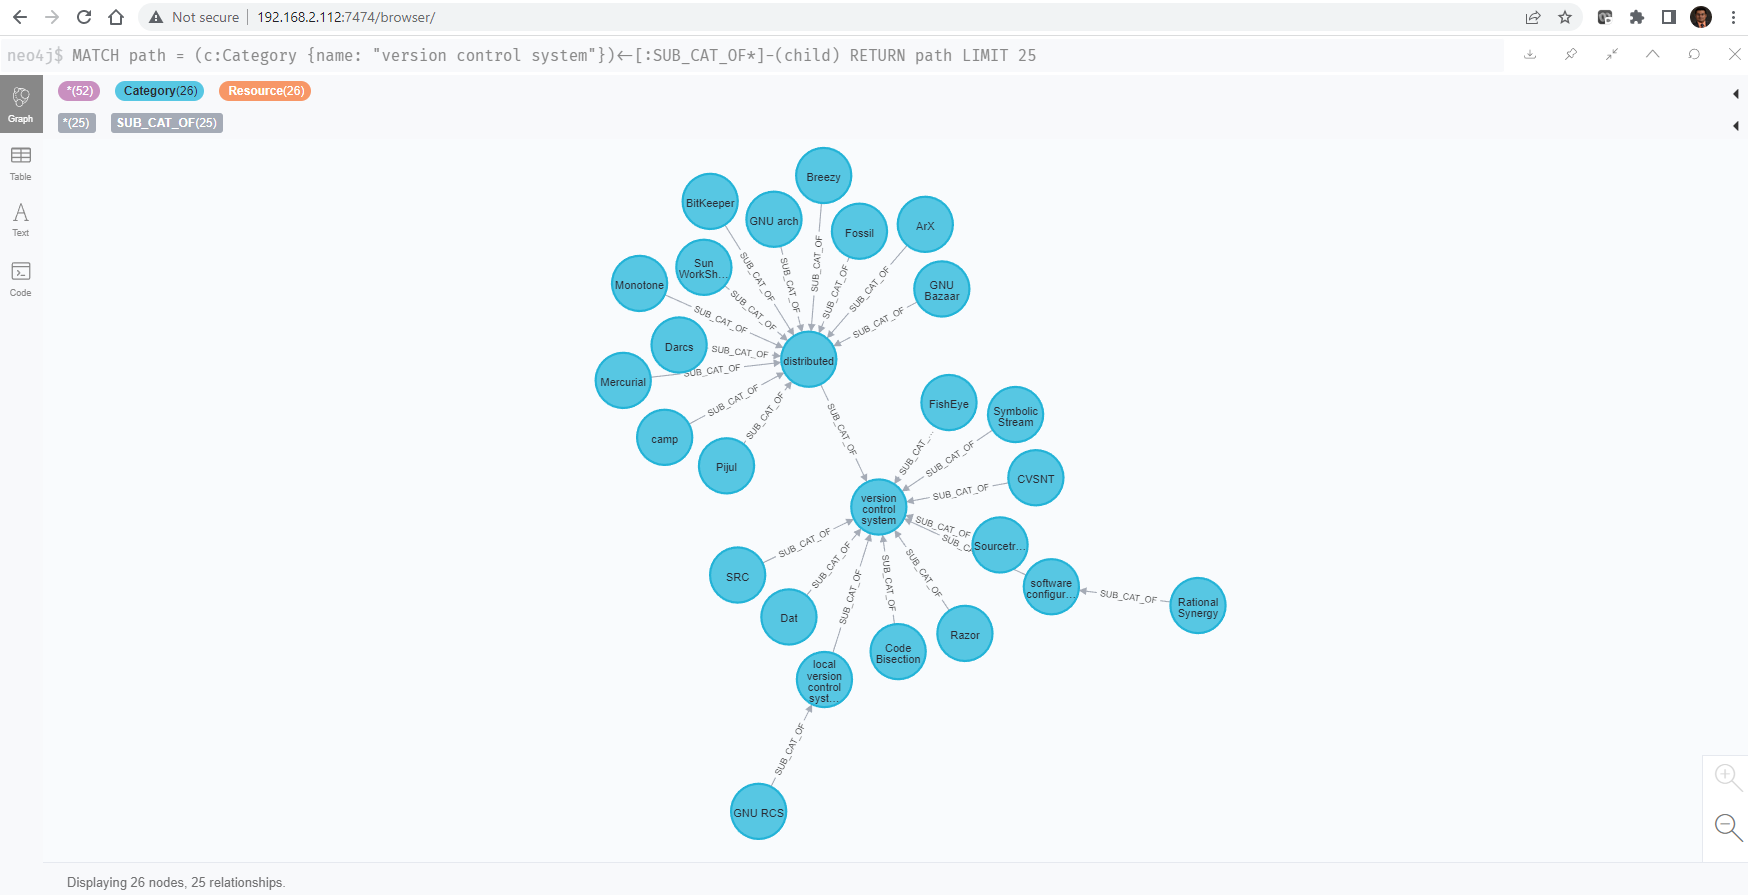

//To See 250 children that are subcategories of "version control system"
```
MATCH path = (c:Category {name: "version control system"})<-[:SUB_CAT_OF*]-(child)
RETURN path
LIMIT 250;
```

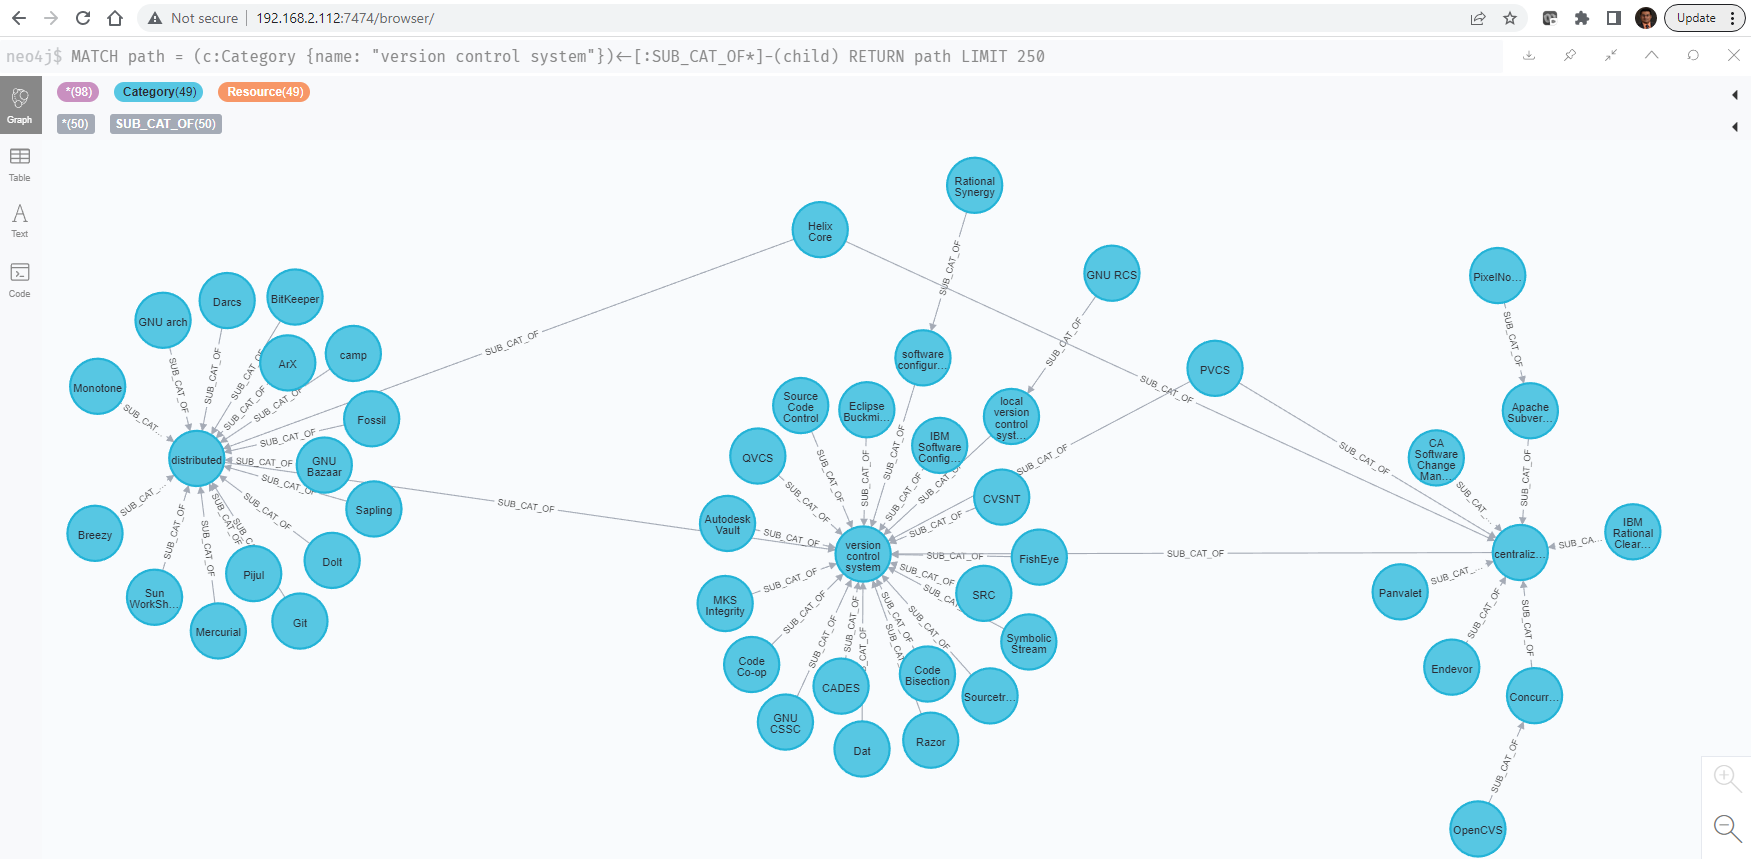

#### 1.2 Find all siblings of the Category "Neo4J" in vocabulary

This is done by navigating to the (root) element of :Category{name:"Neo4J"} and then descending the graph

//Paste the following to Neo4J Browser at http://localhost:7474, neo4j$
```
MATCH path = (:Category {name: "Neo4j"})-[:SUB_CAT_OF*]->(root)<-[:SUB_CAT_OF]-(sibling)
WHERE not((root)-[:SUB_CAT_OF]->())
RETURN path
LIMIT 50;
```

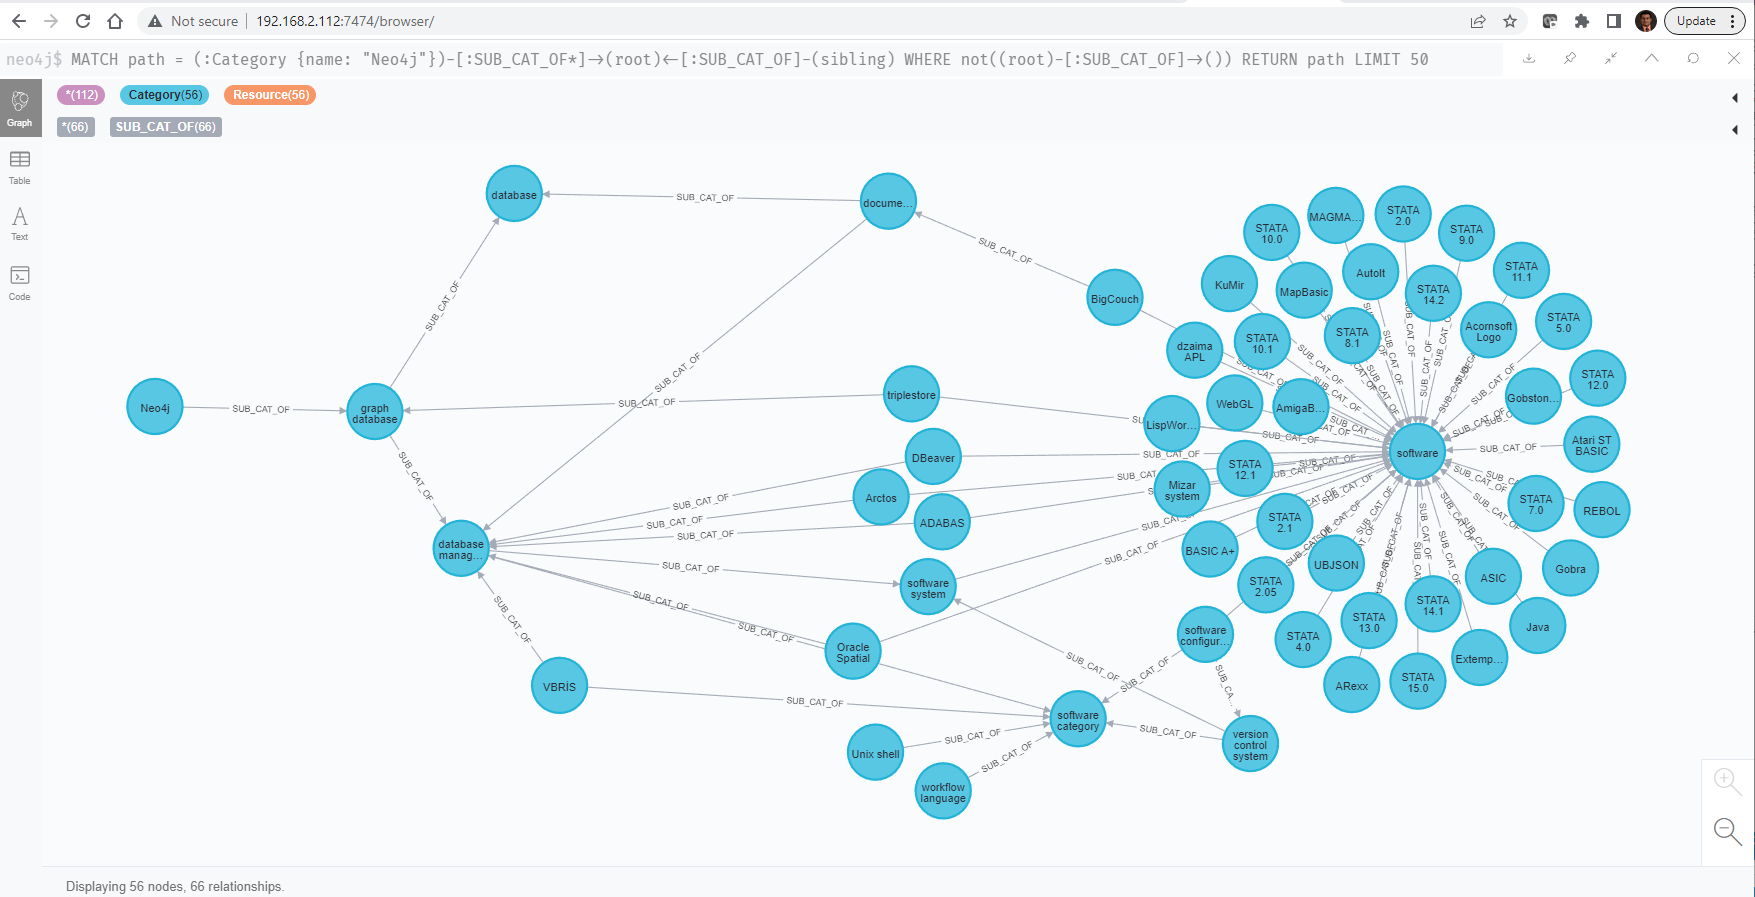

## 2. Importing Facts (Data)

The example uses dev.to articles specified as live URLs (in a CSV file - https://github.com/neo4j-examples/nlp-knowledge-graph/raw/master/import/articles.csv )


In [26]:
#Import dev.to articles into Neo4j. articles.csv contains some blog posts about popular tech topics
input="""
LOAD CSV WITH HEADERS FROM 'https://github.com/neo4j-examples/nlp-knowledge-graph/raw/master/import/articles.csv' AS row
RETURN row
LIMIT 10;
"""
res=conn.query(input)
print(res)

[<Record row={'uri': 'https://dev.to/lirantal/securing-a-nodejs--rethinkdb--tls-setup-on-docker-containers'}>, <Record row={'uri': 'https://dev.to/setevoy/neo4j-running-in-kubernetes-e4p'}>, <Record row={'uri': 'https://dev.to/divyanshutomar/introduction-to-redis-3m2a'}>, <Record row={'uri': 'https://dev.to/zaiste/15-git-commands-you-may-not-know-4a8j'}>, <Record row={'uri': 'https://dev.to/alexjitbit/removing-files-from-mercurial-history-1b15'}>, <Record row={'uri': 'https://dev.to/michelemauro/atlassian-sunsetting-mercurial-support-in-bitbucket-2ga9'}>, <Record row={'uri': 'https://dev.to/shirou/back-up-prometheus-records-to-s3-via-kinesis-firehose-54l4'}>, <Record row={'uri': 'https://dev.to/ionic/farewell-phonegap-reflections-on-my-hybrid-app-development-journey-10dh'}>, <Record row={'uri': 'https://dev.to/rootsami/rancher-kubernetes-on-openstack-using-terraform-1ild'}>, <Record row={'uri': 'https://dev.to/jignesh_simform/comparing-mongodb--mysql-bfa'}>]


In [32]:
#Import the content of these CSV files into the Graph Data Model
#This is done using apoc.load.html() procedure to extract the body and title from each of these articles.
input="""
CALL apoc.periodic.iterate(
  "LOAD CSV WITH HEADERS FROM 'https://github.com/neo4j-examples/nlp-knowledge-graph/raw/master/import/articles.csv' AS row
   RETURN row",
  "MERGE (a:Article {uri: row.uri})
   WITH a
   CALL apoc.load.html(a.uri, {
     body: 'body div.spec__body p',
     title: 'h1',
     time: 'time'
   })
   YIELD value
   UNWIND value.body AS item
   WITH a,
        apoc.text.join(collect(item.text), '') AS body,
        value.title[0].text AS title,
        value.time[0].attributes.datetime AS date
   SET a.body = body , a.title = title, a.datetime = datetime(date)",
  {batchSize: 5, parallel: true}
)
YIELD batches, total, timeTaken, committedOperations
RETURN batches, total, timeTaken, committedOperations;
"""
res=conn.query(input)
print(res)

[<Record batches=7 total=32 timeTaken=0 committedOperations=0>]


In [29]:
input="""
MATCH (a:Article)
RETURN a.uri, a.title, a.body, a.datetime
ORDER BY a.datetime DESC;
"""
res=conn.query(input)
print(res)

[]


### 2.1 Entity Extraction on acquired data

This is done using APOC in this example. 
APOC is Neo4j’s standard utility library.
It includes over 450 standard procedures, providing functionality for utilities, conversions, graph updates, and more.
It has procedures that wrap the Natural Language Processing APIs for the major cloud providers, AWS, GCP, and Azure.

https://neo4j.com/labs/apoc/5/nlp/

https://neo4j.com/labs/apoc/5/nlp/gcp/

https://neo4j.com/labs/apoc/5/nlp/aws/

https://neo4j.com/labs/apoc/5/nlp/azure/


In [ ]:
//This is API Key that has access to the Cloud Natural Language API by going to https://console.cloud.google.com/apis/credentials 
input="""
:params key => ("<insert key>")
"""
res=conn.query(input)
print(res)

#### Step 1 - Perform Entity Extraction of the Body of the Text of Article a 
Articles a have a.uri, a.title, a.body, a.datetime
param $key must been inserted to call GCP APIs


In [ ]:
input="""
CALL apoc.periodic.iterate(
  "MATCH (a:Article)
   WHERE not(exists(a.processed))
   RETURN a",
  "CALL apoc.nlp.gcp.entities.stream([item in $_batch | item.a], {
     nodeProperty: 'body',
     key: $key
   }) 
   YIELD node, value
   SET node.processed = true
   WITH node, value
   UNWIND value.entities AS entity
   WITH entity, node
   WHERE not(entity.metadata.wikipedia_url is null)
   MERGE (page:Resource {uri: entity.metadata.wikipedia_url})
   SET page:WikipediaPage
   MERGE (node)-[:HAS_ENTITY]->(page)",
  {batchMode: "BATCH_SINGLE", batchSize: 10, params: {key: $key}})
YIELD batches, total, timeTaken, committedOperations
RETURN batches, total, timeTaken, committedOperations;
"""
res=conn.query(input)
print(res)

## 3. Querying the Knowledge Graph - Semantic Search

We write a query that starts from a top level :Category and finds all the articles attached to the underlying taxonomy. 
The n10s.inference.nodesInCategory procedure automates this

Here node returns all such nodes of the Taxonomy/Vocabulary of Wikidata specific to the Category "NoSQL" using `n10s.inference.nodesInCategory`
Selected Nodes are matched to the dev.to Articles entity-extracted earlier (through the [:HAS_ENTITY] relationship 

We use `n10s.rdf.getIRILocalName` for the first search 


In [ ]:
input="""
MATCH (c:Category {name: "NoSQL database management system"})
CALL n10s.inference.nodesInCategory(c, {
  inCatRel: "ABOUT",
  subCatRel: "SUB_CAT_OF"
})
YIELD node
MATCH (node)<-[:HAS_ENTITY]-(article)
RETURN article.uri AS uri, article.title AS title, article.datetime AS date,
       collect(n10s.rdf.getIRILocalName(node.uri))  as explicitTopics
ORDER BY date DESC
LIMIT 5;
"""
res=conn.query(input)
print(res)

//This is saying that the articles from dev.to ---> whose entities were extracted --> Match with these explicit topics which are either about or sub-categories 
of the category "NoSQL database management system"
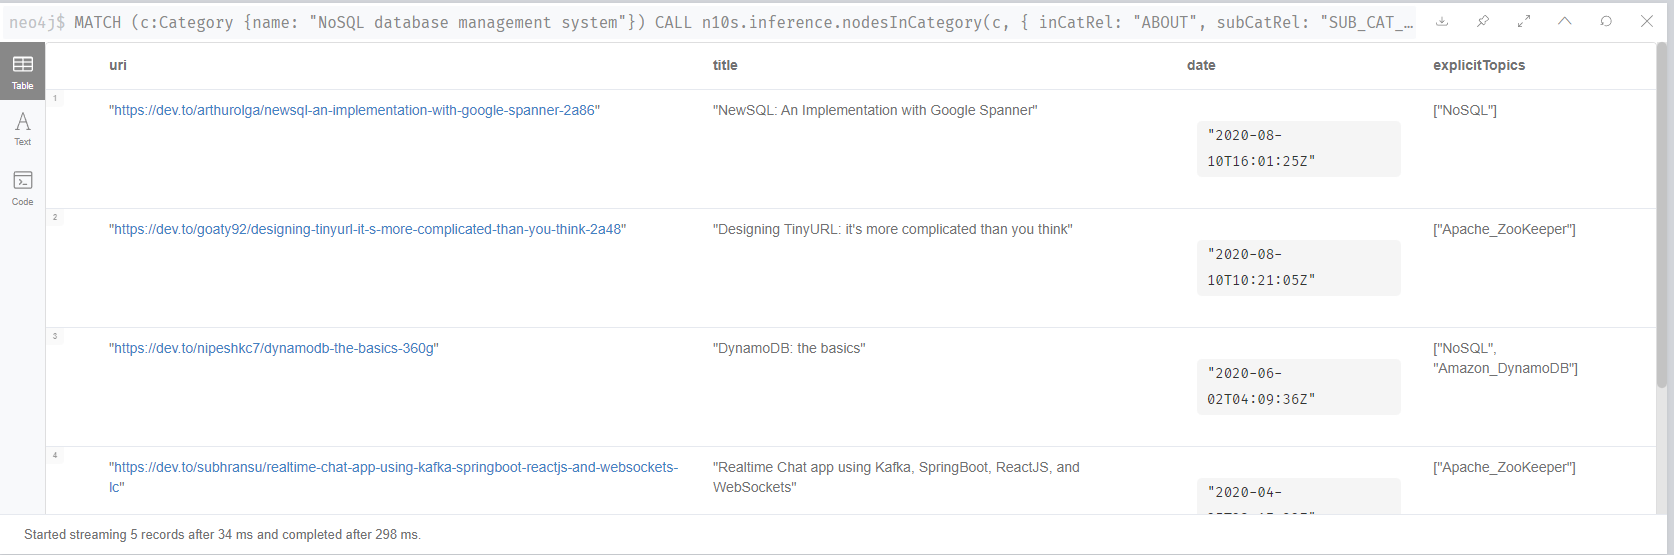

### 3.1 Querying the Knowledge Graph for "Similar" Articles

Using this entity mapping to Software Categories to Map an article to other similar articles

//Paste the following to Neo4J Browser at http://localhost:7474, neo4j$
```
MATCH (a:Article {uri: "https://dev.to/qainsights/performance-testing-neo4j-database-using-bolt-protocol-in-apache-jmeter-1oa9"}),
      path = (a)-[:HAS_ENTITY]->(wiki)-[:ABOUT]->(cat),
      otherPath = (wiki)<-[:HAS_ENTITY]-(other)
return path, otherPath;
```

Article a on "performance testing neo4J" has entity relationship with software taxonomy Wikipedia Structure data  (Software systems, Programming Languages, Data formats)
article -HAS_ENTITY-> to certain Wiki entries. Which in turn has :ABOUT relationship with Categories. Print that path
Note the Comma. This makes a compound query or cartesian product of two queries https://stackoverflow.com/questions/34089692/what-does-a-comma-in-a-cypher-query-do

otherPath is a second Query to match those wiki nodes that have a link with other articles. These will be similar articles  to the selected article a
print the category in the straight path and other articles in the otherPath as similarArticles 


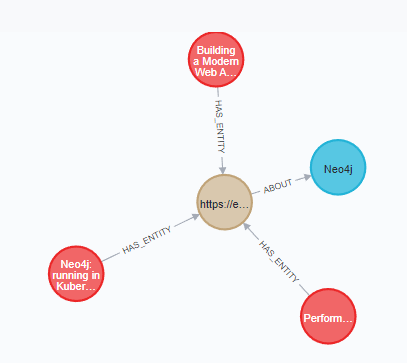

### 3.1 Querying the Knowledge Graph for MORE "Similar" Articles

Using this entity mapping to Software Categories to Map an article to other similar articles

Expanding scope beyond the previous case by navigating the Vocabulary to their parent and finding other sub-categories `otherCat`
otherCat will be peers of cat

Now search otherEntityPath in exactly reverse of entityPath using othercat as base and navigating to other articles (other)
This simply increases the number of similar articles returned as similar articles.

Further do something smart. Not only return other.title and other.uri
Now navigate that tree to link to its wikipedia taxonomy --> Category names as otherCategories
And list those nodes as other possible pathsToOther


//Paste the following to Neo4J Browser at http://localhost:7474, neo4j$
```
MATCH (a:Article {uri: "https://dev.to/qainsights/performance-testing-neo4j-database-using-bolt-protocol-in-apache-jmeter-1oa9"}),
      entityPath = (a)-[:HAS_ENTITY]->(wiki)-[:ABOUT]->(cat),
      path = (cat)-[:SUB_CAT_OF]->(parent)<-[:SUB_CAT_OF]-(otherCat),
      otherEntityPath = (otherCat)<-[:ABOUT]-(otherWiki)<-[:HAS_ENTITY]-(other)
RETURN other.title, other.uri,
       [(other)-[:HAS_ENTITY]->()-[:ABOUT]->(entity) | entity.name] AS otherCategories,
       collect([node in nodes(path) | node.name]) AS pathToOther;
```

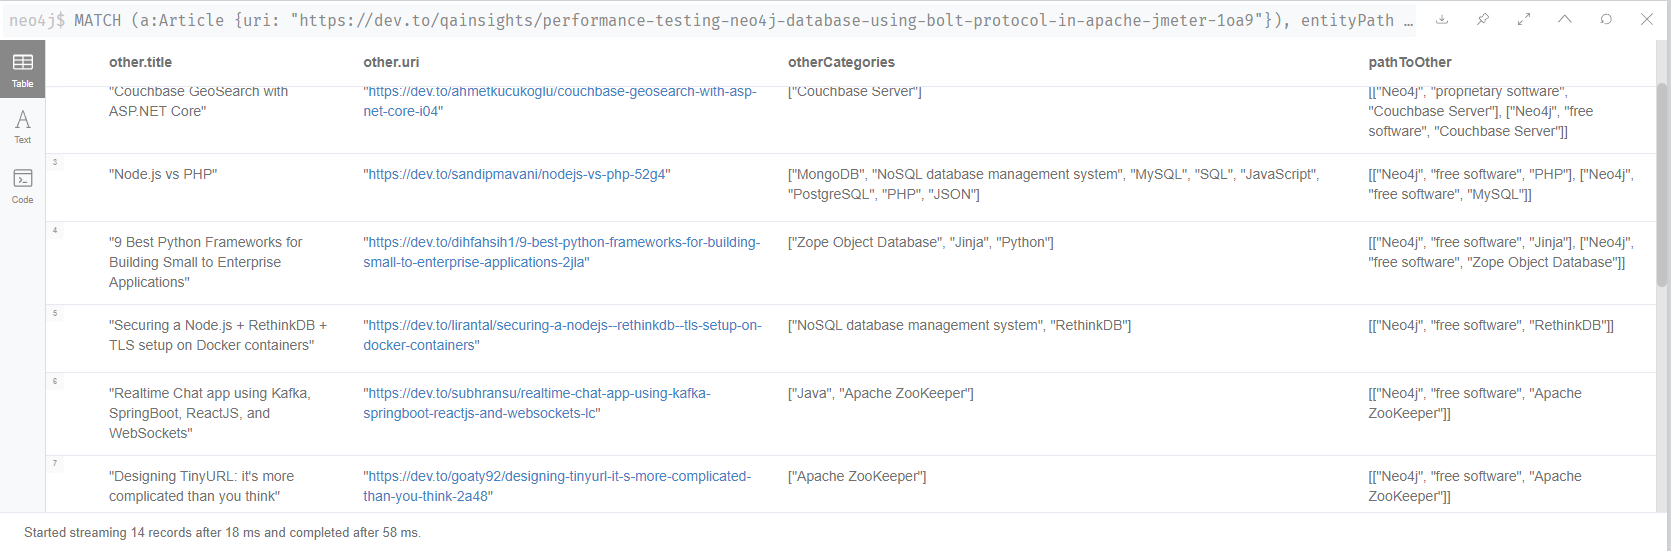

## 4. Adding a Custom Ontology to the Knowledge Graph (Domain specific)

To make a knowledge graph more enriched, it is possible to add a custom ontology. In this example, this will be of the GRANDstack.

https://blog.grandstack.io/
https://blog.graphqleditor.com/grandstack

GRAND stack = GraphQL, React, Apollo and Neo4j Database.

GraphQL is a Schema Definition Language is language agnostic which makes it perspect for interacting with other technologies
React is a component based JavaScript library used for creating User Interfaces. 
Apollo is a powerful tool which basically focuses on making using GraphQL easier on the side of the client and the server.
Neo4J Database


### 4.1 Add the constrainst and mapping for this new ontology

In [ ]:
#Procedure is same as Step 1 in this notebook
#Add a new Ontology

# Configure n10s
config_n10s="""CALL n10s.nsprefixes.add('owl','http://www.w3.org/2002/07/owl#');
CALL n10s.nsprefixes.add('rdfs','http://www.w3.org/2000/01/rdf-schema#');
CALL n10s.mapping.add("http://www.w3.org/2000/01/rdf-schema#subClassOf","SUB_CAT_OF");
CALL n10s.mapping.add("http://www.w3.org/2000/01/rdf-schema#label","name");
CALL n10s.mapping.add("http://www.w3.org/2002/07/owl#Class","Category");
"""
conn.multi_query(config_n10s)


//Preview the topology the Turtle Serialized RDF Schema we want to import.
//This is a brief ontology of the GRAND stack.
//Paste the following to Neo4J Browser at http://localhost:7474, neo4j$
```
CALL n10s.rdf.preview.fetch("http://www.nsmntx.org/2020/08/swStacks","Turtle");
```

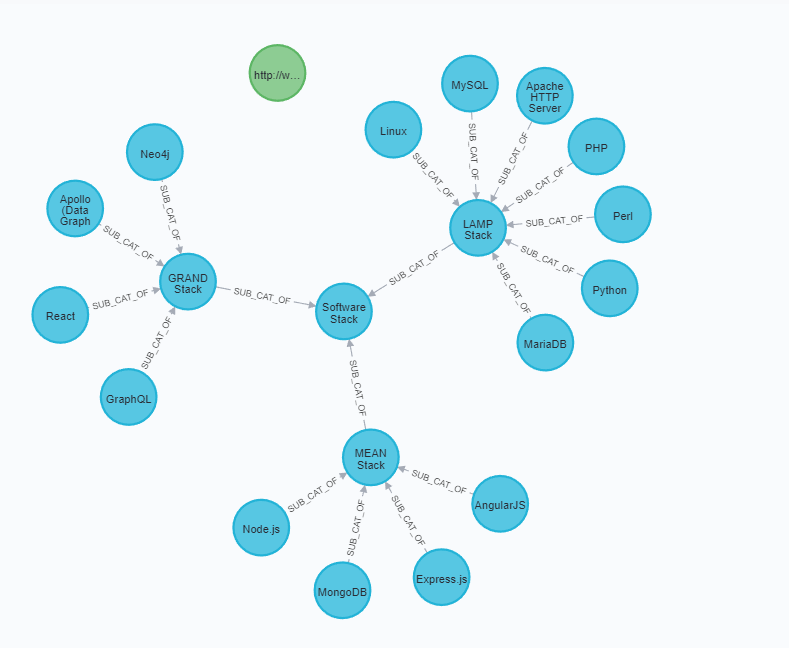

### 4.2 Import Taxonomy (Wikidata Software)

Import the GrandStack Software  ontology

In [ ]:
//#Import RDF Triples relating to Grandstack Software
input="""CALL n10s.rdf.import.fetch("http://www.nsmntx.org/2020/08/swStacks","Turtle")
YIELD terminationStatus, triplesLoaded, triplesParsed, namespaces, callParams
RETURN terminationStatus, triplesLoaded, triplesParsed, namespaces, callParams;
"""
res=conn.query(input)
print(res)


### 4.3 Querying the Knowledge Graph - Similar articles
And now if we try our similarity query again (same as 3.1), we’ll see articles linked via the Categories relating to GRANDstack

In [ ]:
input="""
MATCH (a:Article {uri: "https://dev.to/qainsights/performance-testing-neo4j-database-using-bolt-protocol-in-apache-jmeter-1oa9"}),
      entityPath = (a)-[:HAS_ENTITY]->(wiki)-[:ABOUT]->(cat),
      path = (cat)-[:SUB_CAT_OF]->(parent)<-[:SUB_CAT_OF]-(otherCat),
      otherEntityPath = (otherCat)<-[:ABOUT]-(otherWiki)<-[:HAS_ENTITY]-(other)
RETURN other.title, other.uri,
       [(other)-[:HAS_ENTITY]->()-[:ABOUT]->(entity) | entity.name] AS otherCategories,
       collect([node in nodes(path) | node.name]) AS pathToOther;
"""
res=conn.query(input)
print(res)

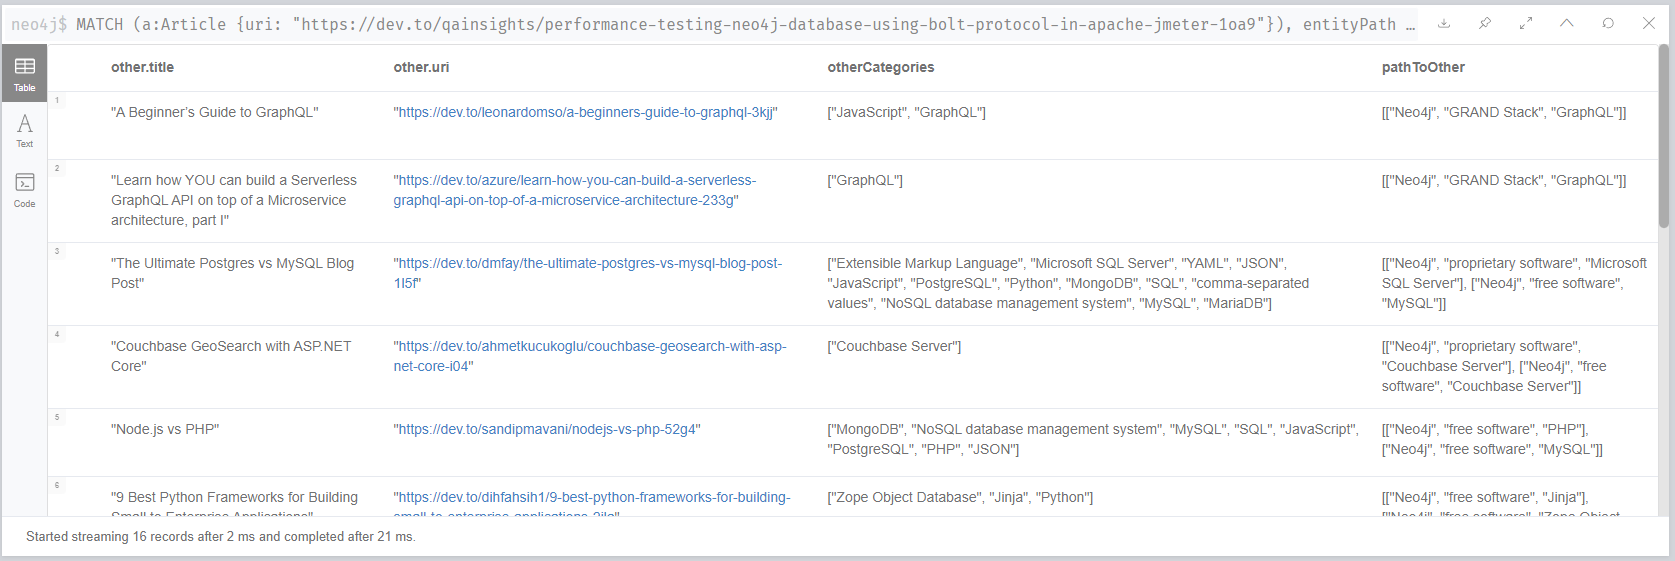